In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.stats
from scipy.interpolate import interp1d

pi = np.pi

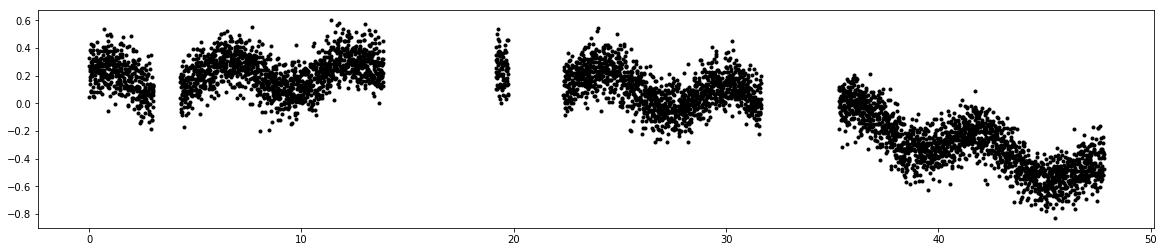

In [2]:
# make some synthetic data
N = 10000       # number of datapoints
fdrop = 0.2     # fraction of dropped cadences
ngaps = 6       # number of large gaps to generate

c = np.random.normal(size=10)

xt = np.linspace(0,51,N)

yt = c[0]*10 + c[1]/1e2*xt + c[2]/1e4*xt**2 + c[3]/1e6*xt**3 
yt += c[4]/4*np.sin(2*pi*c[5]/10*xt - c[6]) + c[7]/2*np.sin(2*pi*c[8]/100*xt - c[9])
yt += 0.1*np.random.normal(size=N)


# remove random cadences and make some big gaps
bad = np.random.uniform(0,1,size=len(xt)) < fdrop

# make some big gaps
gap_locs = np.random.choice(np.arange(len(xt)), size=ngaps)
gap_lens = np.random.randint(N//100,N//10, size=ngaps)

for i, gloc in enumerate(gap_locs):
    bad[gloc:gloc+gap_lens[i]] = True

xt = xt[~bad]
yt = yt[~bad]

plt.figure(figsize=(20,4))
plt.plot(xt, yt, 'k.')
plt.show()

In [3]:
def rolling_std(x, winsize):
    """
    Calculate a rolling standard deviation on a 1D vector
    
    Parameters
    ----------
    x : array-like
        array of (N,) data values
    winsize : int
        size of window for rolling standard deviation
        
    Returns
    -------
    rstd : ndarray
        size (N,) array for rolling standard deviation at each point in x
    """
    N = len(x)
    
    xpad = np.pad(x, (winsize//2, winsize//2), mode="reflect")
    rstd = np.zeros(N)
    
    for i in range(N):
        rstd[i] = np.std(xpad[i+winsize//2:i+winsize+winsize//2])
    
    return rstd

In [4]:
def fill_gaps(x, y, break_tolerance=8, return_mask=False):
    """
    This algorithm assumes:
        (1) the data are nearly uniformly sampled over at least some significant uninterupted segment
        (2) the underlying sampling cadence remains constant over time with only discrete cadences missing
        (3) the noise level remains roughly constant over the course of the observations
        (4) trends in the data are reasonably well behaved
        
    If these conditions are not met this method may fail catastrophically
    
    Parameters
    ----------
        x : array-like
            1D data array of x values (e.g. time)
        y : array-like
            1D data array of y values (e.g. flux)
        break_tolerance : int
            number of cadences to consider a large gap; should be small compared to len(x); default = 8
        return_mask : bool
            if set to True, return a mask flagging where data were interpolated
            
    Returns
    -------
        xfill : ndarray
            uniformly sampled x values
        yfill : ndarray
            y values interpolated to uniform sampling
        mask : ndarray
            boolean array; 1 = real data, 0 = interplated (only returned if return_mask == True)
    """
    # determine baseline noise level
    rstd = np.mean(rolling_std(y, winsize=np.min([len(y)//10,100])))
    
    # determine underlying uniform sampling frequency
    dx = np.min(x[1:]-x[:-1])

    # set up interpolated arrays
    xfill = np.arange(np.min(x), np.max(x)+dx/2, dx)
    yfill = np.zeros_like(xfill)
    
    cadno = np.arange(len(xfill))
    data_exists = np.isin(cadno, np.array(np.floor((x-np.min(x) + dx/2)/dx), dtype="int"))
    
    yfill[data_exists] = y
    yfill[~data_exists] = interp1d(x,y)(xfill[~data_exists])
    
    
    # identify locations of large gaps
    gaps = cadno[data_exists][1:]-cadno[data_exists][:-1]
    gaps = np.pad(gaps, (1,0), 'constant', constant_values=(1,0))
    
    right = cadno[data_exists][gaps > break_tolerance]
    left  = cadno[data_exists][np.where(np.isin(cadno[data_exists], right))[0] - 1] + 1
    
    gap_locs = np.stack([left, right]).swapaxes(0,1)
    
    # make a boolean mask for the gaps (1 = data, 0 = gap)
    # this is not quite the same as "data_exists" because it treats interpolation over small gaps as "real" data
    gap_mask = np.ones_like(data_exists)
    
    for i, gloc in enumerate(gap_locs):
        gap_mask[gloc[0]:gloc[1]] = False

    for i, gloc in enumerate(gap_locs):
        n = gloc[1]-gloc[0]
        
        # make lefthand reflection (add white noise where needed)
        if gloc[0] > n:
            x_ = np.copy(xfill[gloc[0]-n:gloc[0]])
            y_ = np.copy(yfill[gloc[0]-n:gloc[0]])[::-1]
            m_ = np.copy(gap_mask[gloc[0]-n:gloc[0]])[::-1]
            w_ = np.linspace(1,0,len(m_))
                        
            if np.sum(m_) > n/2:
                pfit = np.polyfit(x_[m_], y_[m_], 1)
                y_[~m_] = np.polyval(pfit, x_[~m_]) + rstd*np.random.normal(size=np.sum(~m_))
            else:
                y_[~m_] = (np.ones(n)*np.sum(w_[m_]*y_[m_])/np.sum(w_[m_]) + rstd*np.random.normal(size=n))[~m_]
                
            left = np.copy(y_)

        
        else:
            x_ = np.copy(xfill[:gloc[0]])
            y_ = np.copy(yfill[:gloc[0]])[::-1]
            m_ = np.copy(gap_mask[:gloc[0]])[::-1]
            w_ = np.linspace(0,1,len(m_))
            
            try:
                left = np.ones(n)*np.mean(y_[m_][:break_tolerance]) + rstd*np.random.normal(size=n)
            except:
                left = np.ones(n)*np.mean(y_[m_]) + rstd*np.random.normal(size=n)
        
        
        # make righthand reflection
        if gloc[1] + n < len(xfill):
            x_ = np.copy(xfill[gloc[1]:gloc[1]+n])
            y_ = np.copy(yfill[gloc[1]:gloc[1]+n])[::-1]
            m_ = np.copy(gap_mask[gloc[1]:gloc[1]+n])[::-1]
            w_ = np.linspace(0,1,len(m_))
            
            if np.sum(m_) > n/2:
                pfit = np.polyfit(x_[m_], y_[m_], 1)
                y_[~m_] = np.polyval(pfit, x_[~m_]) + rstd*np.random.normal(size=np.sum(~m_))
            else:
                y_[~m_] = (np.ones(n)*np.sum(w_[m_]*y_[m_])/np.sum(w_[m_]) + rstd*np.random.normal(size=n))[~m_]
            
            right = np.copy(y_)
            
        else:
            x_ = np.copy(xfill[gloc[1]:])
            y_ = np.copy(yfill[gloc[1]:])[::-1]
            m_ = np.copy(gap_mask[gloc[1]:])[::-1]
            w_ = np.linspace(1,0,len(m_))
            
            try:
                right = np.ones(n)*np.mean(y_[m_][-break_tolerance:]) + rstd*np.random.normal(size=n)
            except:
                right = np.ones(n)*np.mean(y_[m_]) + rstd*np.random.normal(size=n)        
        
        # weighted mean (with noise adjustment to prevent noise suppression)
        w = np.linspace(0,1,n)
        z = 1/np.sqrt(w**2 + w[::-1]**2)
        
        mean = w[::-1]*left + w*right
        mean += (1-z)*rstd*np.random.normal(size=n)

        yfill[gloc[0]:gloc[1]] = mean*1.0


    if return_mask:
        return xfill, yfill, data_exists
    else:
        return xfill, yfill

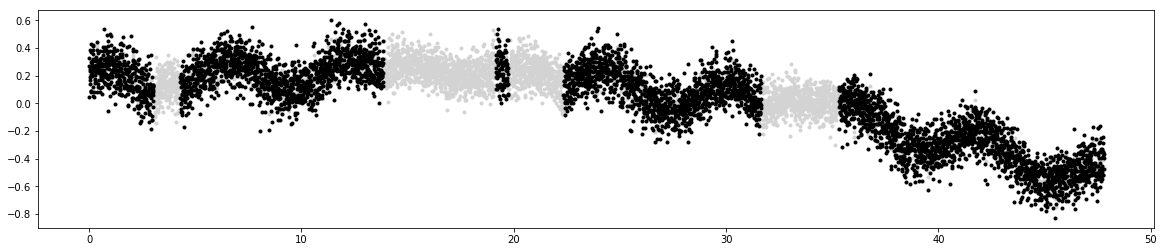

In [5]:
xf, yf, mf = fill_gaps(xt, yt, return_mask=True)

plt.figure(figsize=(20,4))
plt.plot(xf[~mf], yf[~mf], '.', color="lightgrey")
plt.plot(xf[mf], yf[mf], '.', color="k")
plt.show()